In [ ]:
!pip install pydub

In [ ]:
import os
from pydub import AudioSegment
from sklearn.model_selection import train_test_split

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# # Verilerin ve sınıfların yolları
# data_dir = '/content/drive/MyDrive/SongsTest'
# output_dir = '/content/drive/MyDrive/SongTestSegments'
# classes = ['CountryTest', 'EDMTest', 'Hip Hop-RapTest', 'PopTest', 'R&BTest', 'RockTest']

# # Çıktı dizinini oluşturma
# os.makedirs(output_dir, exist_ok=True)

In [ ]:
data_dir = '/content/drive/MyDrive/yazlab/divide'

In [ ]:
classes = ['azerice', 'kazakca', 'kirgizca', 'ozbekce', 'turkce']

In [ ]:
# # Drive klasör erişim kontrolleri için - Bu kısım Drive'daki dosyaların önbelleğe alınıp kolay erişilebilmesi için gereklidir.
# for class_name in classes:
#     class_output_dir = os.path.join(output_dir, class_name)
#     try:
#         file_list = os.listdir(class_output_dir)
#         print(f"Directory '{class_output_dir}' contains {len(file_list)} files.")
#     except OSError as e:
#         print(f"Error accessing directory {class_output_dir}: {e}")

In [ ]:
# # Her bir sınıf için ses dosyalarını işleme
# for label, class_name in enumerate(classes):
#     class_dir = os.path.join(data_dir, class_name)
#     class_output_dir = os.path.join(output_dir, class_name)
#     os.makedirs(class_output_dir, exist_ok=True)

#     for filename in os.listdir(class_dir):
#         if filename.endswith('.mp3 adlı dosyanın kopyası'):
#             file_path = os.path.join(class_dir, filename)
#             audio = AudioSegment.from_file(file_path, format='mp3')

#             # 10 saniyelik segmentlere ayırma
#             duration = 10 * 1000  # 10 saniye milisaniye cinsinden
#             for i in range(0, len(audio), duration):
#                 segment = audio[i:i + duration]
#                 if len(segment) < duration:
#                     segment = segment + AudioSegment.silent(duration - len(segment))  # 10 saniyeye tamamla
#                 segment_filename = f'{os.path.splitext(filename)[0]}_{i // duration}.mp3'
#                 segment_path = os.path.join(class_output_dir, segment_filename)
#                 segment.export(segment_path, format='mp3')

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from pydub import AudioSegment
import io
import librosa

In [ ]:
import numpy as np
from tqdm import tqdm

# Segmentleri ve etiketleri yüklemek için listeler
segments = []
labels = []

for label, class_name in enumerate(classes):
    class_data_dir = os.path.join(data_dir, class_name)

    # İlerleme göstergesi için tqdm kullanımı
    files = [f for f in os.listdir(class_data_dir) if f.endswith('.wav')]
    for filename in tqdm(files, desc=f"Loading {class_name} segments"):
        file_path = os.path.join(class_data_dir, filename)

        try:
            # `librosa` ile ses dosyasını yükleyin
            audio, sr = librosa.load(file_path, sr=16000)
            segment_array = np.array(audio)

            # Check if the segment array has the same shape as the others
            if segments and segment_array.shape != segments[0].shape:
                # Normalize and fix the length of the segment array
                segment_array = librosa.util.normalize(segment_array)
                segment_array = librosa.util.fix_length(segment_array, size=segments[0].shape[0])

            segments.append(segment_array)
            labels.append(label)

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

# Sonuçları kontrol etme
print(f"Loaded {len(segments)} segments with corresponding labels.")

Loading levantine segments: 100%|██████████| 3017/3017 [02:21<00:00, 21.32it/s]

Loaded 15220 segments with corresponding labels.


In [ ]:
# Segmentleri ve etiketleri numpy dizilerine dönüştürme
segments_np = np.array(segments)
labels_np = np.array(labels)

In [ ]:
# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(segments_np, labels_np, test_size=0.2, random_state=42)

In [ ]:
print(f'Toplam dosya sayısı: {len(segments_np)}')
print(f'Eğitim seti dosya sayısı: {len(X_train)}')
print(f'Test seti dosya sayısı: {len(X_test)}')

Toplam dosya sayısı: 15220
Eğitim seti dosya sayısı: 12176
Test seti dosya sayısı: 3044


In [ ]:
from transformers import HubertForSequenceClassification, Wav2Vec2FeatureExtractor
import torch
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# ASTFeatureExtractor'ı başlatma
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-ks")

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [ ]:
# Ses verilerini özelliklere dönüştürme
X_train_features = feature_extractor(X_train, sampling_rate=16000, return_tensors="pt")
X_test_features = feature_extractor(X_test, sampling_rate=16000, return_tensors="pt")

In [ ]:
# Numpy verilerini PyTorch tensörlerine dönüştürme ve DataLoader oluşturma
train_dataset = TensorDataset(X_train_features['input_values'], torch.tensor(y_train))
test_dataset = TensorDataset(X_test_features['input_values'], torch.tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
# ASTForAudioClassification modelini başlatma
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-ks", num_labels=len(classes), ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at superb/hubert-large-superb-ks were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-ks and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametri

In [ ]:
# Optimizasyon fonksiyonunu tanımlama
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Kayıp fonksiyonu tanımlama
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertLayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (pro

In [ ]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for batch in train_loader:
        input_values, labels = batch
        input_values = input_values.to(device)
        labels = labels.to(device)

        outputs = model(input_values.to(device))
        logits = outputs.logits.to(device)
        loss = loss_fn(logits, labels)

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(train_loader), correct_predictions.double() / len(train_loader.dataset)

In [ ]:
all_preds = []
all_labels = []

def eval_model(model, test_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in test_loader:
            input_values, labels = batch
            input_values = input_values.to(device)
            labels = labels.to(device)

            outputs = model(input_values.to(device))
            logits = outputs.logits.to(device)
            loss = loss_fn(logits, labels)

            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(test_loader), correct_predictions.double() / len(test_loader.dataset), all_preds, all_labels

In [ ]:
num_epochs = 5
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    test_loss, test_acc, test_preds, test_labels = eval_model(model, test_loader, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Train Loss: {train_loss}, Train Accuracy: {train_acc}')
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Epoch 1/5
Train Loss: 0.7091875303834653, Train Accuracy: 0.743511826544021
Test Loss: 0.10028683758189619, Test Accuracy: 0.9668199737187911
Epoch 2/5
Train Loss: 0.1183430264107614, Train Accuracy: 0.9641097240473062
Test Loss: 0.052672874747968404, Test Accuracy: 0.9898160315374508
Epoch 3/5
Train Loss: 0.09179990128122355, Train Accuracy: 0.9715834428383706
Test Loss: 0.029882020263600696, Test Accuracy: 0.9924441524310118
Epoch 4/5
Train Loss: 0.03220647892951296, Train Accuracy: 0.9912122207621551
Test Loss: 0.02494984800701436, Test Accuracy: 0.9940867279894875
Epoch 5/5
Train Loss: 0.04700417717869118, Train Accuracy: 0.9843134034165572
Test Loss: 0.4319239679050057, Test Accuracy: 0.9050591327201052


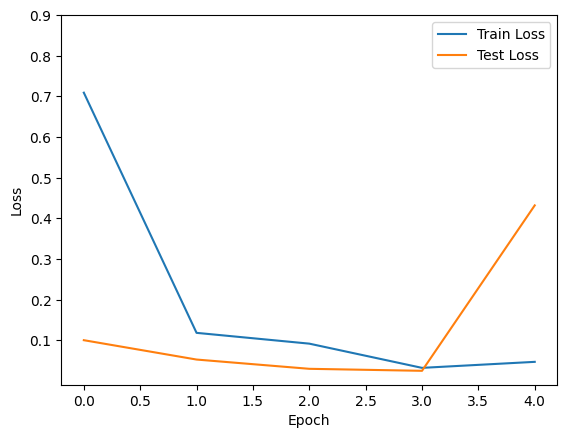

In [ ]:
# Accuracy ve loss grafikleri
plt.figure()
plt.subplot(1, 1, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yticks([i/10 for i in range(1, 10)])
plt.legend()

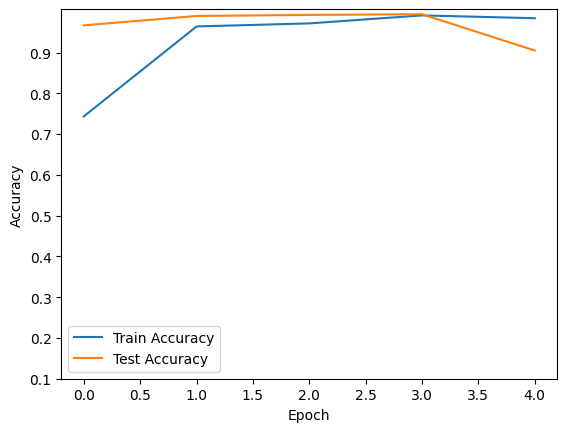

In [ ]:
# plt.subplot(1, 2, 2)
# plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
# plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# Train accuracy verilerini CPU belleğine kopyala
train_accuracies_cpu = [acc.cpu().numpy() for acc in train_accuracies]
test_accuracies_cpu = [acc.cpu().numpy() for acc in test_accuracies]

# Grafik çizdirme işlemi
plt.figure()
plt.subplot(1, 1, 1)
plt.plot(range(num_epochs), train_accuracies_cpu, label='Train Accuracy')
plt.plot(range(num_epochs), test_accuracies_cpu, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks([i/10 for i in range(1, 10)])
plt.legend()

In [ ]:
plt.show()

In [ ]:
# Precision, Recall, F1-Score hesaplama
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Precision: 0.970570567003924
Recall: 0.9694863150310645
F1-Score: 0.9690012114251276


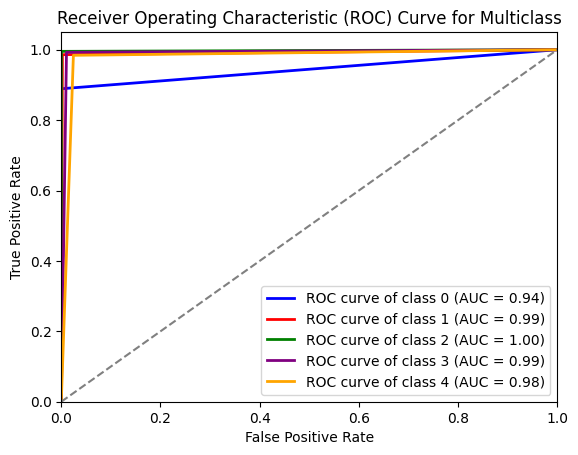

In [ ]:
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import label_binarize

labels = np.array(all_labels)
preds = np.array(all_preds)

# Sınıfları ikili hale getirin
n_classes = len(np.unique(labels))
labels = label_binarize(labels, classes=[0, 1, 2, 3, 4])
preds = label_binarize(preds, classes=[0, 1, 2, 3, 4])

# Her sınıf için ROC ve AUC hesapla
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC eğrisini çizdir
plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc="lower right")
plt.show()

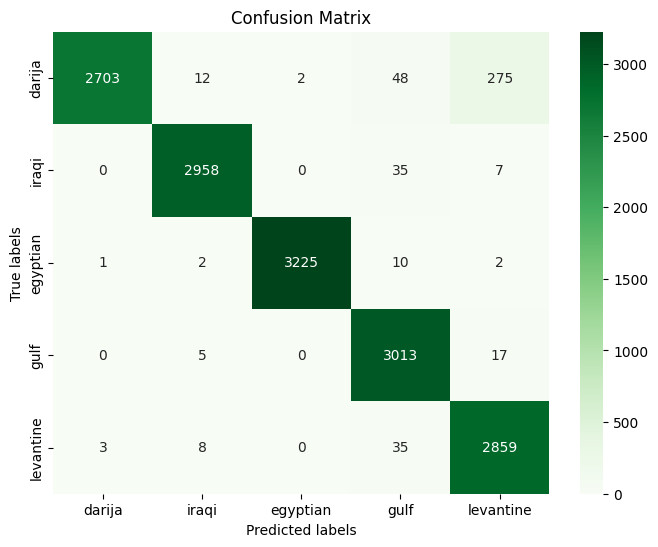

In [ ]:
# Confusion matrix oluştur
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Sınıfları ikili hale getirin
class_names = ['darija', 'iraqi', 'egyptian', 'gulf', 'levantine']

# Classification report oluştur
report = classification_report(labels, preds, target_names=class_names, output_dict=True)

# DataFrame'e dönüştür ve precision ve recall sütunlarını seç
df_report = pd.DataFrame(report).transpose()
df_precision_recall = df_report[['precision', 'recall']]

# Precision ve recall değerlerini tablo olarak yazdır
print(df_precision_recall)

              precision    recall
darija         0.998522  0.889145
iraqi          0.990955  0.986000
egyptian       0.999380  0.995370
gulf           0.959249  0.992751
levantine      0.904747  0.984165
micro avg      0.969645  0.969645
macro avg      0.970571  0.969486
weighted avg   0.971483  0.969645
samples avg    0.969645  0.969645


In [ ]:
import torch

# Eğitim sonrası modeli kaydetme
model_save_path = '/content/drive/MyDrive/saved_models/hubert_pretrained.pth'  # Modelin kaydedileceği dosya yolu
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/saved_models/hubert_pretrained.pth
